In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os

from dl import authClient as ac, queryClient as qc
from collections import Counter
from tqdm import tqdm
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from numba import njit, vectorize, char, int8, jit
from utils.analyze_lensing import make_lensing_dataframe
from utils.filtering import lens_filter
from utils.effective_monitoring_time import effective_monitoring_time


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
base_dir = "/dlusers/adriansh/work/analyses/"
fig_dir = os.path.join(base_dir, "plots/strings/12aug2024/")
results_dir = os.path.join(base_dir, "results/strings/12aug2024/")

In [2]:
SECONDS_PER_DAY = 86400
FILTER_ORDER = {f: i for i, f in enumerate(['u', 'g', 'r', 'i', 'z', 'Y', "VR"])}

def _filter_map(char):
    result = FILTER_ORDER[char]
    return result

filter_map = np.vectorize(_filter_map, otypes=[np.int64])

def count_samples(df):
    n_samples = len(df)
    n_baseline = df["cluster_label"].sum()
    n_bright = n_samples - n_baseline
    data = {"n_baseline": [n_baseline], "n_bright": [n_bright]}
    result = pd.DataFrame(data=data, index=[df.iloc[0, 0]])
    return result

def is_multichromatic(s):
    vals = Counter(s).values()
    result = (len(vals) > 1) and ((np.array(list(vals)) > 1).all())
    return result

def biggest_diff(chars):
    x = np.array([FILTER_ORDER[k] for k in list(set(chars))])
    result = x.max() - x.min()
    return result

def finite_average_delta_t(s):

    if np.isfinite(s["t_start_max"]):
        ts_max = s["t_start_max"]
    else:
        ts_max = s["t_start_min"]

    if np.isfinite(s["t_end_max"]):
        te_max = s["t_end_max"]
    else:
        te_max = s["t_end_min"]

    ts_min = s["t_start_min"]
    te_min = s["t_end_min"]
    result = ((te_max - ts_max) + (te_min - ts_min)) / 2
    return result

def t_of_tau(taus, ts):
    t0, t1, t2, t3 = ts
    t_max = np.min([t1 - t0, t3 - t2])
    tau_min = t2 - t1
    tau_max = t3 - t0
    tau_med = (tau_max + tau_min) / 2
    x = taus - tau_min
    x_med = tau_med - tau_min
    x_max = tau_max - tau_min
    y = np.piecewise(x, [x < x_med, x >= x_med], [lambda xx: xx, lambda xx: x_max - xx])
    result = np.clip(y, a_min=0, a_max=t_max)
    return result

def event_duration_posterior(taus, ts):
    result = np.zeros(taus.shape)

    if ~(np.isfinite(ts).all()):
        result[-1] = 1
    else:
        t0, t1, t2, t3 = ts
        t_max = np.min([t1 - t0, t3 - t2])
        tau_min = t2 - t1
        tau_max = t3 - t0
        tau_vertices = np.array([tau_min, tau_min + t_max, tau_max - t_max, tau_max])
        x = np.concatenate((taus, tau_vertices))
        mask = np.concatenate((np.full(taus.shape, True), np.full(tau_vertices.shape, False)))
        indices = np.argsort(x)
        x = x[indices]
        mask = mask[indices]
        vertex_idxs = np.nonzero(~mask)[0]
        y = t_of_tau(x, ts)
        y_av = (y[1:] + y[:-1]) / 2
        dx = np.diff(x)
        integral = y_av * dx
        integral[np.clip(vertex_idxs - 1, a_min=0, a_max=None)] += integral[vertex_idxs]
        result[:-1] = integral[mask[:-1]]

    return result

In [3]:
lc_df_all = pd.read_parquet(f"{results_dir}lightcurves.parquet")
internal_times_all = pd.read_parquet(f"{results_dir}internal_times.parquet")
aggregates_all = pd.read_parquet(f"{results_dir}aggregates.parquet")
lc_classes_all = pd.read_parquet(f"{results_dir}lc_classes.parquet")

In [7]:
lc_df_all.to_parquet(f"{results_dir}lightcurves.parquet")
internal_times_all.to_parquet(f"{results_dir}internal_times.parquet")
aggregates_all.to_parquet(f"{results_dir}aggregates.parquet")
lc_classes_all.to_parquet(f"{results_dir}lc_classes.parquet")

In [4]:
# Roll this stuff up in some functions
g = lc_df_all.groupby(by="objectid", sort=False)
achrom = dict(achromatic=True, factor_of_two=False)
achrom2 = dict(achromatic=True, factor_of_two=True)

lc_df_achrom = g.filter(lambda group: lens_filter(group, **achrom))
lc_df_achrom2 = g.filter(lambda group: lens_filter(group, **achrom2))

results_df_all = make_lensing_dataframe(lc_df_all)
filter_diffs_all = results_df_all["filters"].apply(biggest_diff)
n_samples_all = lc_df_all.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_all.index.name = "objectid"
results_df_all = results_df_all.assign(achromatic=results_df_all["filters"].apply(lambda x: len(set(x)) > 1),
                                       multiplicity_2=results_df_all["filters"].apply(is_multichromatic),
                                       n_bright=results_df_all["filters"].apply(lambda x: len(x)))

results_df_achrom = make_lensing_dataframe(lc_df_achrom)
filter_diffs_achrom = results_df_achrom["filters"].apply(biggest_diff)
n_samples_achrom = lc_df_achrom.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_achrom.index.name = "objectid"
results_df_achrom = results_df_achrom.assign(achromatic=results_df_achrom["filters"].apply(lambda x: len(set(x)) > 1),
                                             multiplicity_2=results_df_achrom["filters"].apply(is_multichromatic),
                                             n_bright=results_df_achrom["filters"].apply(lambda x: len(x)))

results_df_achrom2 = make_lensing_dataframe(lc_df_achrom2)
filter_diffs_achrom2 = results_df_achrom2["filters"].apply(biggest_diff)
n_samples_achrom2 = lc_df_achrom2.groupby("objectid", group_keys=False).apply(count_samples)
n_samples_achrom2.index.name = "objectid"
results_df_achrom2 = results_df_achrom2.assign(achromatic=results_df_achrom2["filters"].apply(lambda x: len(set(x)) > 1),
                                               multiplicity_2=results_df_achrom2["filters"].apply(is_multichromatic),
                                               n_bright=results_df_achrom2["filters"].apply(lambda x: len(x)))

In [5]:
lc_df_all.sort_values(by=["objectid", "mjd"], inplace=True)
results_df_all.sort_index(level=0, inplace=True)

lc_df_achrom.sort_values(by=["objectid", "mjd"], inplace=True)
results_df_achrom.sort_index(level=0, inplace=True)

lc_df_achrom2.sort_values(by=["objectid", "mjd"], inplace=True)
results_df_achrom2.sort_index(level=0, inplace=True)

n_events_all = results_df_all.groupby(level=0).filters.agg("count")
n_events_all.name = "n_events"
n_events_all.sort_index(inplace=True)

n_events_achrom = results_df_achrom.groupby(level=0).filters.agg("count")
n_events_achrom.name = "n_events"
n_events_achrom.sort_index(inplace=True)

n_events_achrom2 = results_df_achrom2.groupby(level=0).filters.agg("count")
n_events_achrom2.name = "n_events"
n_events_achrom2.sort_index(inplace=True)

In [6]:
filters_in_event_all = results_df_all["filters"].apply(lambda x: "".join(sorted(set(x))))
filters_in_event_achrom = results_df_achrom["filters"].apply(lambda x: "".join(sorted(set(x))))
filters_in_event_achrom2 = results_df_achrom2["filters"].apply(lambda x: "".join(sorted(set(x))))

filters_in_event_hist_all = filters_in_event_all.value_counts()
filters_in_event_hist_achrom = filters_in_event_achrom.value_counts()
filters_in_event_hist_achrom2 = filters_in_event_achrom2.value_counts()

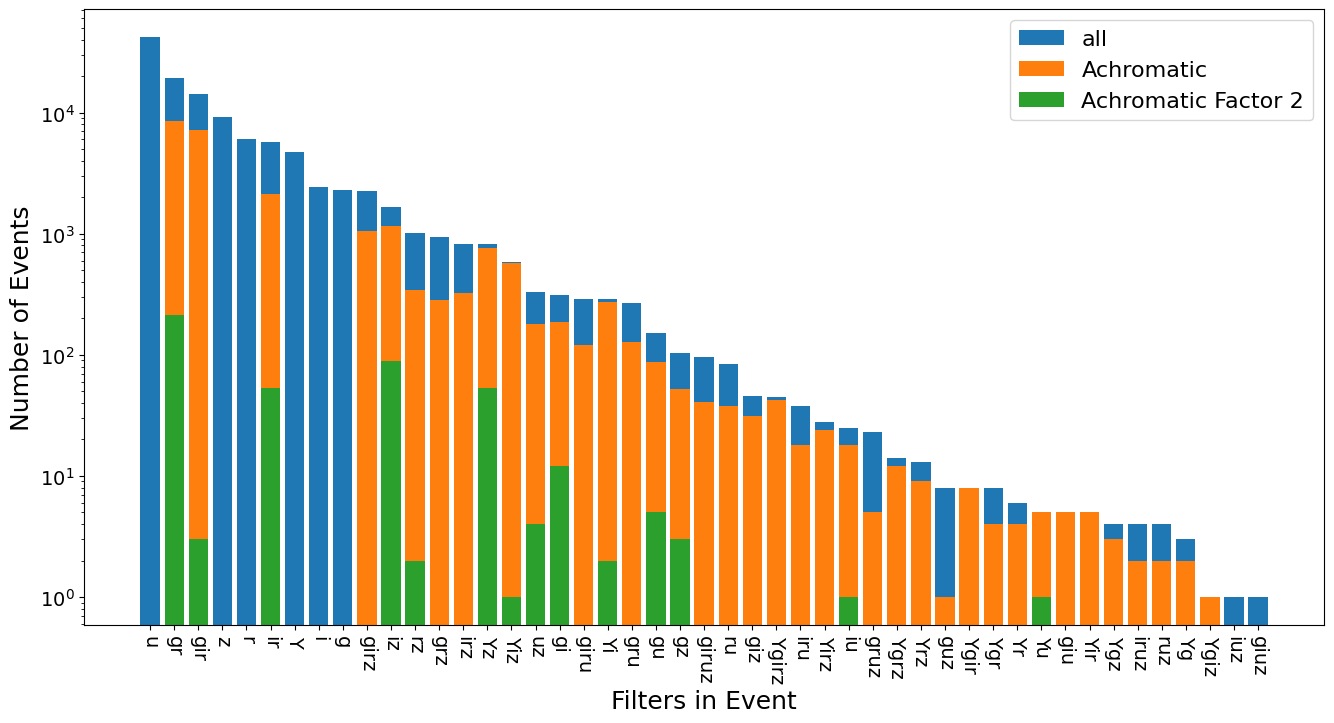

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(filters_in_event_hist_all.index, filters_in_event_hist_all, label="all")
ax.bar(filters_in_event_hist_achrom.index, filters_in_event_hist_achrom, label="Achromatic")
ax.bar(filters_in_event_hist_achrom2.index, filters_in_event_hist_achrom2, label="Achromatic Factor 2")
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
fig.savefig(f"{fig_dir}filters_in_event.png")
plt.show(fig)

In [8]:
n_events_per_source_all = results_df_all.groupby(level=0).t_start_max.agg("count")
n_events_per_source_achrom = results_df_achrom.groupby(level=0).t_start_max.agg("count")
n_events_per_source_achrom2 = results_df_achrom2.groupby(level=0).t_start_max.agg("count")

In [9]:
n_events_freq_all = n_events_per_source_all.value_counts()
n_events_freq_achrom = n_events_per_source_achrom.value_counts()
n_events_freq_achrom2 = n_events_per_source_achrom2.value_counts()

n_events_freq_all.index.name = "n_events"
n_events_freq_achrom.index.name = "n_events"
n_events_freq_achrom2.index.name = "n_events"

In [10]:
n_events_freq_all.name = "all"
n_events_freq_achrom.name = "achromatic"
n_events_freq_achrom2.name = "achromatic_factor2"
temp = pd.Series(np.zeros(n_events_freq_all.index.max() + 1), name="temp")

n_events_freq_df = pd.concat([n_events_freq_all, n_events_freq_achrom, 
                              n_events_freq_achrom2, temp], axis=1)
n_events_freq_df.index.name = "n_events"
n_events_freq_df.replace(np.nan, 0, inplace=True)
n_events_freq_df.sort_index(inplace=True)
n_events_freq_df.drop(columns="temp", inplace=True)

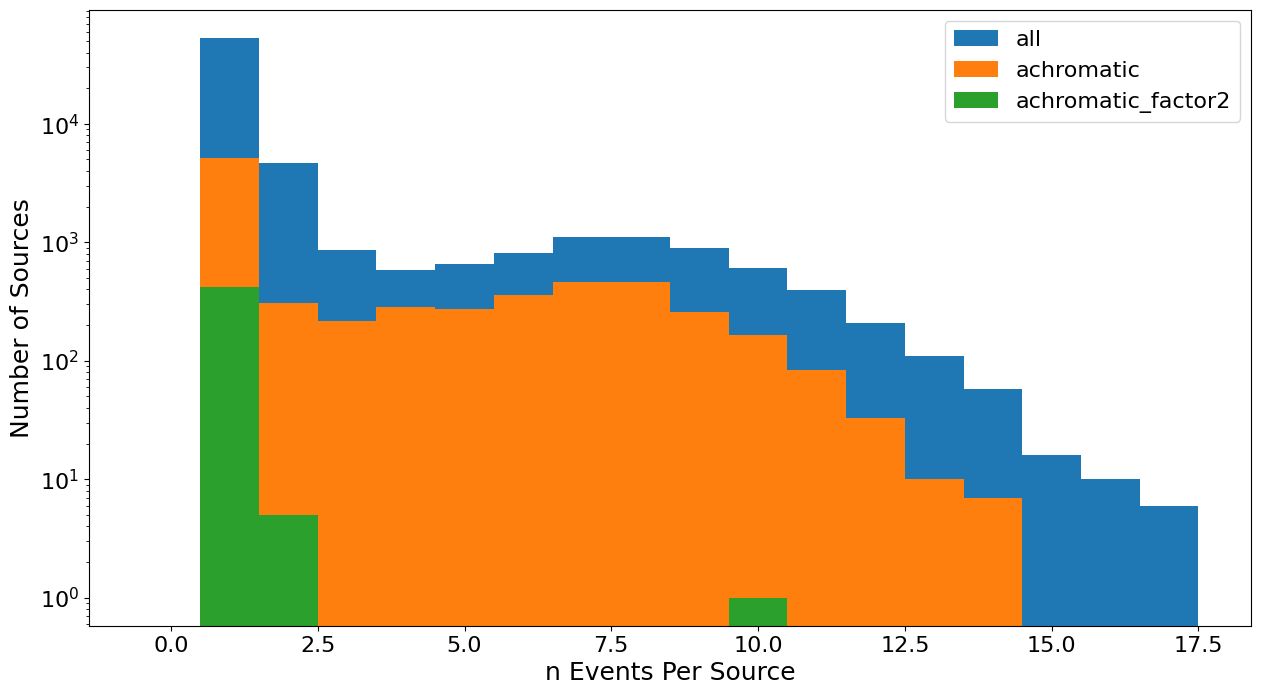

In [11]:
n_events_freq_df.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
# x_ticks = np.arange(0, 10 * np.ceil(n_events_freq_df.index.max() / 10) + 10, 10).astype(int)

for col in n_events_freq_df.columns:
    x = n_events_freq_df[col].index.values
    y = n_events_freq_df[col].values
    ax.bar(x, y, width=1, label=col)

# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_ticks, rotation=-90)
# ax.set_xlim((x_ticks.min(), x_ticks.max()))
ax.legend(loc="upper right", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Number of Sources", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}events_per_source_hist.png")
plt.show(fig)

In [12]:
taus = np.geomspace(1e-4, 1e4, num=50)
hist_counts = np.zeros((3, taus.shape[0]))
dfs = [results_df_all, results_df_achrom, results_df_achrom2]

for j in range(len(dfs)):
    df = dfs[j]
    t_matrix = df[["t_start_max", "t_start_min", "t_end_min", "t_end_max"]].values

    for i in range(t_matrix.shape[0]):
        ts = t_matrix[i]
        post = event_duration_posterior(taus, ts)
        hist_counts[j] += (post / post.sum())

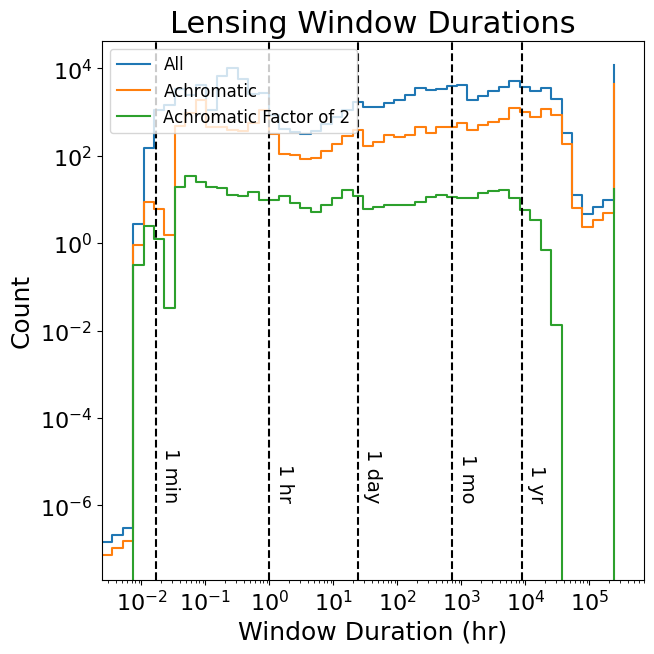

In [13]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 
                            60 * 60 * 24 * 30, 
                            60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
x = taus * 24
labels = ["All", "Achromatic", "Achromatic Factor of 2"]

fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(labels)):
    h = hist_counts[i]
    label = labels[i]
    ax.plot(x, h, ds="steps-post", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((x[0], 3*x[-1]))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.15)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

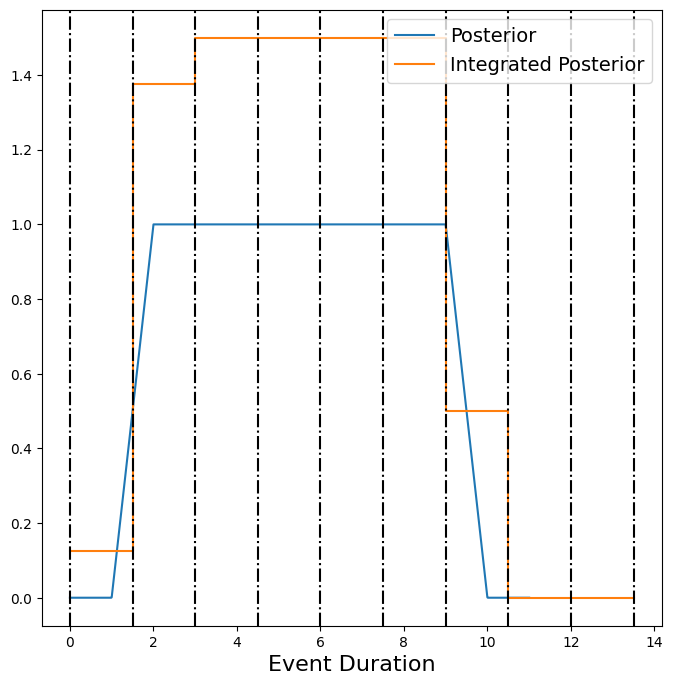

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
bins = np.arange(0, 15, 1.5)
ts = (0, 1, 2, 10)
t0, t1, t2, t3 = ts
x = np.linspace(0, 11, num=1001)
lam = 1/20
ax.plot(x, t_of_tau(x, ts), label="Posterior")
post = event_duration_posterior(bins, ts)
ax.plot(bins, post, ds="steps-post", label="Integrated Posterior")

for b in bins:
    ax.axvline(x=b, color='k', ls="-.")

ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Event Duration", fontsize=16)
plt.show(fig)

In [15]:
n_samples_lc_all = lc_df_all.groupby(by="objectid", sort=False).mag_auto.agg("count")

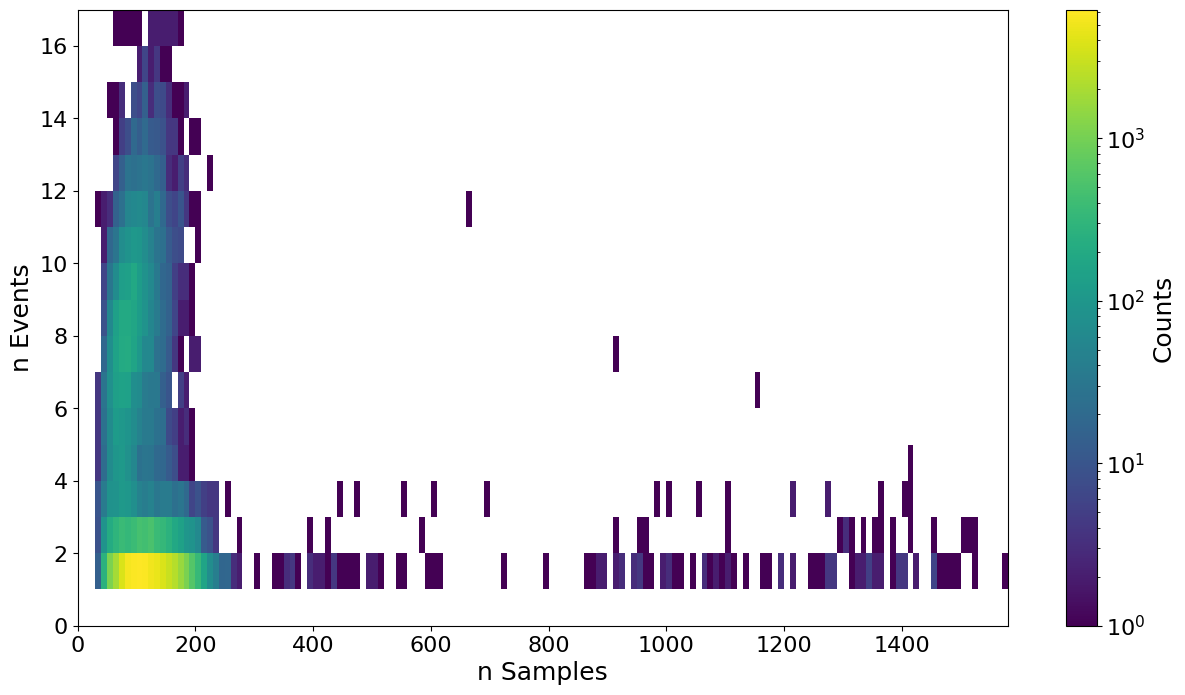

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
# ax.scatter(n_samples_lc, n_events, alpha=0.25, s=4)
hist = ax.hist2d(n_samples_lc_all, n_events_all, 
                 bins=[np.arange(0, n_samples_lc_all.max()+10, 10), 
                       np.arange(0, n_events_all.max()+1)], 
                 norm=LogNorm())

colorbar = plt.colorbar(hist[3], ax=ax)
colorbar.set_label('Counts', fontsize=18)
colorbar.ax.tick_params(labelsize=16)

# ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("n Samples", fontsize=18)
ax.set_ylabel("n Events", fontsize=18)
ax.tick_params(labelsize=16)
m = n_events_all.iloc[0] / n_samples_lc_all.iloc[0]
# ax.set_xlim((0, 250))
# ax.set_ylim((0, 100))
# ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}n_events_n_samples.png")
plt.show(fig)

In [19]:
n_samples_lc_achrom2 = lc_df_achrom2.groupby(by="objectid", sort=False).mag_auto.agg("count")

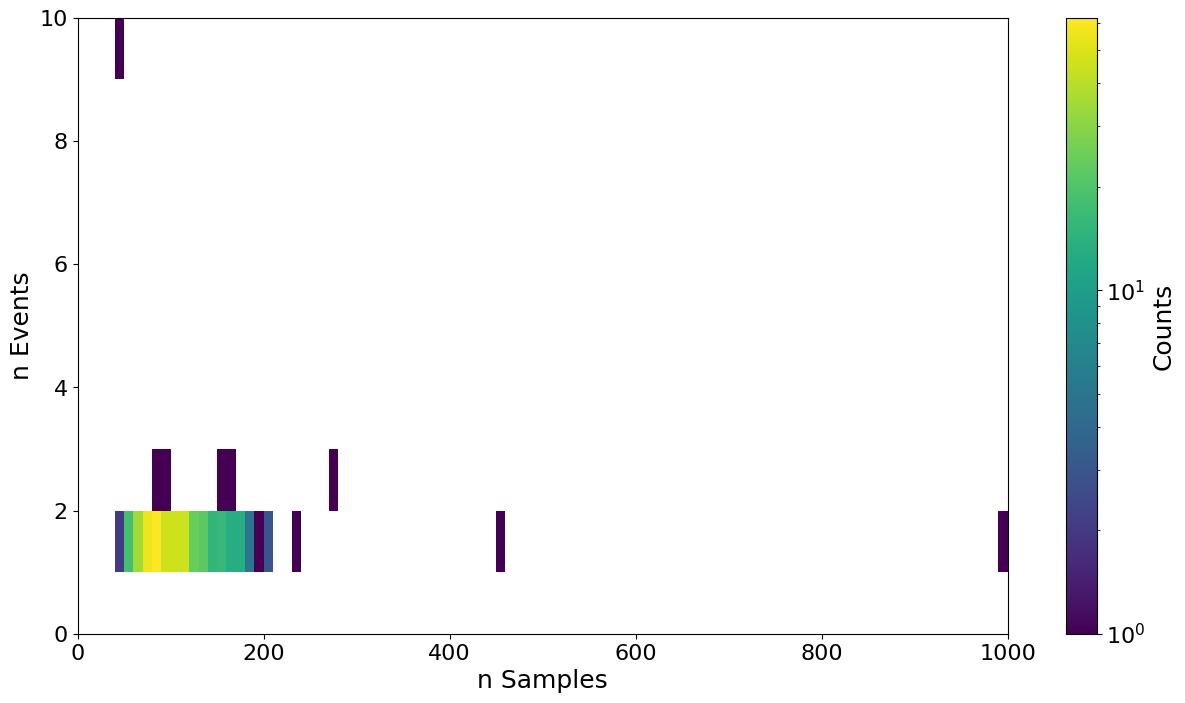

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
# ax.scatter(n_samples_lc, n_events, alpha=0.25, s=4)
hist = ax.hist2d(n_samples_lc_achrom2, n_events_achrom2, 
                 bins=[np.arange(0, n_samples_lc_achrom2.max()+10, 10), 
                       np.arange(0, n_events_achrom2.max()+1)], 
                 norm=LogNorm())

colorbar = plt.colorbar(hist[3], ax=ax)
colorbar.set_label('Counts', fontsize=18)
colorbar.ax.tick_params(labelsize=16)

# ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("n Samples", fontsize=18)
ax.set_ylabel("n Events", fontsize=18)
ax.tick_params(labelsize=16)
# ax.set_xlim((0, 250))
# ax.set_ylim((0, 100))
# ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}n_events_n_samples.png")
plt.show(fig)

In [37]:
unimodal_times = internal_times_all.xs("Unimodal", level=1, drop_level=False)
achrom2_times = effective_monitoring_time(lc_df_achrom2, taus)
achrom2_time_data = np.vstack([achrom2_times[k] 
                               for k in achrom2_times.keys()])
achrom2_index_tuples = ([(1000, "Background", filter_sequence) 
                         for filter_sequence in achrom2_times.keys()])
times_idx = pd.MultiIndex.from_tuples(achrom2_index_tuples)
achrom2_times_df = pd.DataFrame(data=achrom2_time_data, index=times_idx,
                                columns=[f"tau{i}" for i in range(len(taus))])
achrom2_times_df = pd.concat((unimodal_times, achrom2_times_df))
achrom2_times_df.index.set_names(["batch", "star_class", "bright_filters"], inplace=True)

In [38]:
achrom2_times_df.to_parquet(f"{results_dir}effective_monitoring_times_achrom2.parquet")

In [44]:
achrom2_times_df.sum(axis=0)

tau0     0.000000e+00
tau1     0.000000e+00
tau2     0.000000e+00
tau3     0.000000e+00
tau4     8.581291e+01
tau5     7.346629e+02
tau6     3.286557e+03
tau7     5.204285e+03
tau8     2.428814e+04
tau9     3.645538e+04
tau10    1.147783e+05
tau11    3.604459e+05
tau12    7.174772e+05
tau13    1.235361e+06
tau14    1.983185e+06
tau15    3.053074e+06
tau16    4.593580e+06
tau17    6.839593e+06
tau18    1.006369e+07
tau19    1.349145e+07
tau20    1.805893e+07
tau21    2.460674e+07
tau22    3.411903e+07
tau23    4.797036e+07
tau24    6.812911e+07
tau25    9.111182e+07
tau26    1.209773e+08
tau27    1.638709e+08
tau28    2.221657e+08
tau29    3.013175e+08
tau30    4.082809e+08
tau31    5.604154e+08
tau32    7.765522e+08
tau33    1.074655e+09
tau34    1.405146e+09
tau35    1.796052e+09
tau36    2.255768e+09
tau37    2.826593e+09
tau38    3.603505e+09
tau39    4.471990e+09
tau40    5.142547e+09
tau41    5.412846e+09
tau42    5.547668e+09
tau43    4.416261e+09
tau44    2.023700e+09
tau45    1

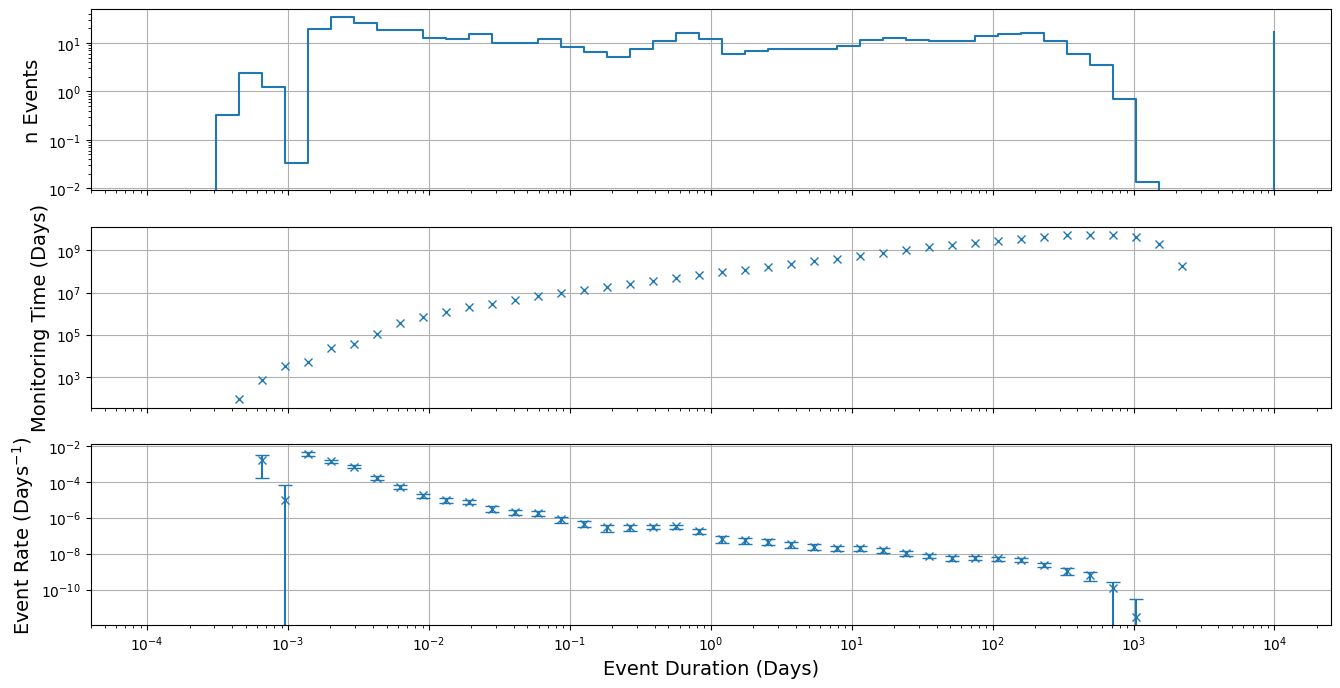

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
y0 = hist_counts[2]
y1 = achrom2_times_df.sum(axis=0).values
m = y1 > 0
y2 = y0[m] / y1[m]

err = np.sqrt(y0[m]) / y1[m]
axes[0].plot(taus, y0, ds="steps-post")
axes[1].errorbar(taus, y1, capsize=5, marker='x', ls="None")
axes[2].errorbar(taus[m][1:], y2[1:], yerr=err[1:], capsize=5, marker='x', ls="None")

for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(visible=True)

axes[0].set_ylabel("n Events", fontsize=14)
axes[1].set_ylabel("Monitoring Time (Days)", fontsize=14)
# axes[0].legend(fontsize=16)
axes[2].set_xlabel("Event Duration (Days)", fontsize=14)
axes[2].set_ylabel(r"Event Rate (Days$^{-1}$)", fontsize=14)
plt.show(fig)
fig.savefig(f"{fig_dir}event_rate_3subplots.png")
plt.close(fig)

/tmp/ipykernel_134998/2300249597.py:4: RuntimeWarning: invalid value encountered in divide
  ax.bar(n_samples_x, n_bright_y / n_samples_y, width=1)


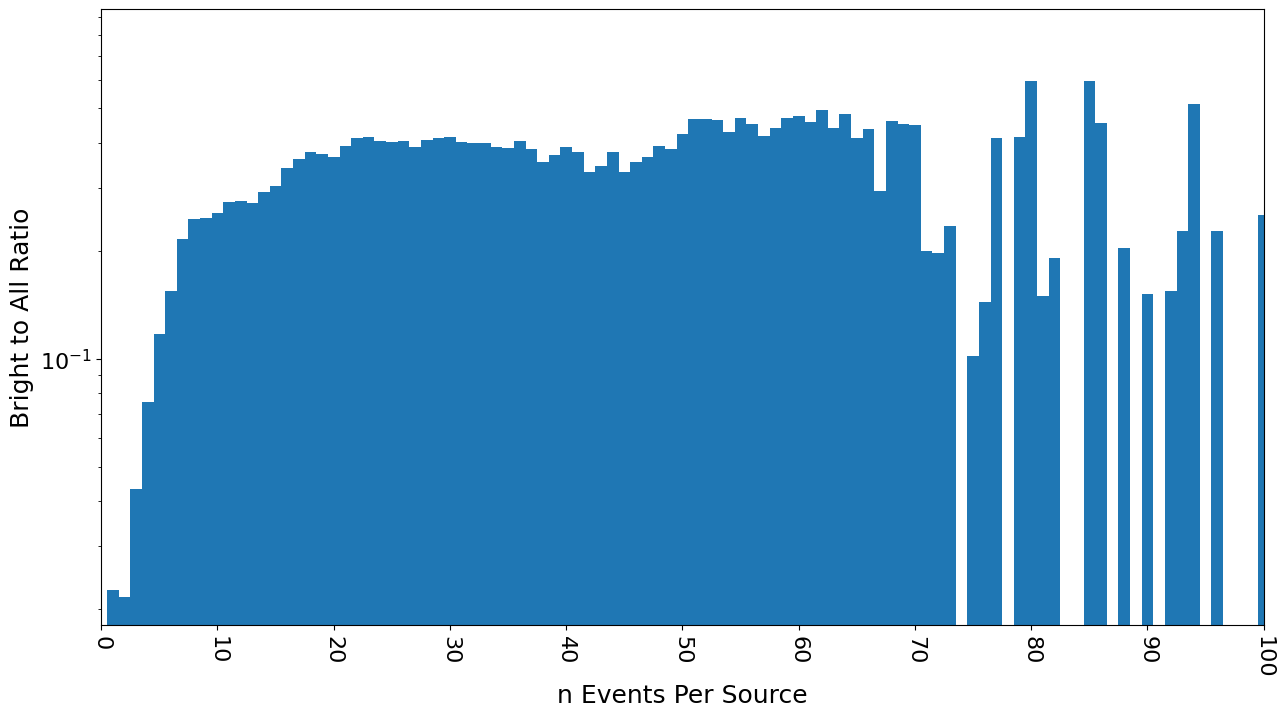

In [88]:
fig, ax = plt.subplots(figsize=(15, 8))
x_ticks = n_samples_x[::10]

ax.bar(n_samples_x, n_bright_y / n_samples_y, width=1)
# ax.plot(n_samples_x, normalizing_curve, color="tab:orange")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=-90)
ax.set_xlim((x_ticks.min(), x_ticks.max()))
# ax.legend(loc="upper right", fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n Events Per Source", fontsize=18)
ax.set_ylabel("Bright to All Ratio", fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}events_per_source_hist.png")
plt.show(fig)

In [115]:
(n_events_freq_df["all"] * n_events_freq_df["all"].index).sum() / n_events_freq_df["all"].sum()

13.199471840391999

In [49]:
filter_diffs_hist = filter_diffs_achromatic_factor.value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(filter_diffs_hist.index, filter_diffs_hist)
ax.set_yscale("log")
ax.set_xlabel("Filter Difference", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}filter_difference_hist.png")
plt.show(fig)

NameError: name 'filter_diffs_achromatic_factor' is not defined

In [51]:
filter_seq_count = results_df.groupby(by="filters").t_start.agg("count")

mask_two_sample_results = results_df["n_bright"] > 1
many_bright_ids = results_df.loc[results_df["n_bright"] > 9].index.get_level_values(0)

two_sample_ids = results_df.loc[mask_two_sample_results].index.get_level_values(0)
mask_two_sample = lc_df["objectid"].isin(two_sample_ids)

achromatic_ids = results_df.loc[results_df["achromatic"]].index.get_level_values(0)
mult2_ids = results_df.loc[results_df["multiplicity_2"]].index.get_level_values(0)
n_achromatic = len(achromatic_ids)

mask_achromatic = lc_df["objectid"].isin(achromatic_ids)
mask_bright = lc_df["cluster_label"] == 0
mask_mult2 = lc_df["objectid"].isin(mult2_ids)

bright_lc = lc_df.loc[mask_bright & mask_two_sample]
bright_achromatic_lc = lc_df.loc[mask_achromatic & mask_bright]
bright_achromatic_mult2_lc = lc_df.loc[mask_achromatic & mask_bright & mask_mult2]

flux_double = -2.5 * np.log10(2)

dmag_bins = np.linspace(-2.5, 0, num=26)
bright_achromatic = lc_df.loc[mask_achromatic & mask_bright]

mean_err = bright_achromatic["magerr_auto"].mean()
sigma_err = bright_achromatic["magerr_auto"].std()

achromatic_results = results_df.loc[results_df["achromatic"]]
achromatic_mult2_results = results_df.loc[results_df["achromatic"] & results_df["multiplicity_2"]]

n_distribution = results_df.loc[mask_two_sample_results].groupby(by="n_bright").filters.agg("count")
n_achromatic_distribution = achromatic_results.groupby(by="n_bright").filters.agg("count")
n_achromatic_mult2_distribution = achromatic_mult2_results.groupby(by="n_bright").filters.agg("count")

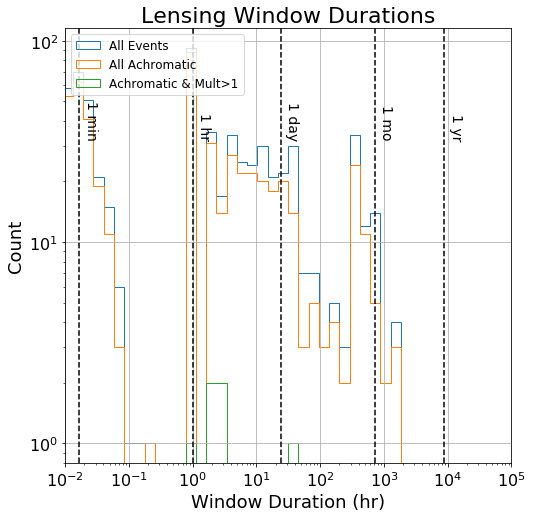

In [45]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
finite_delta_t = np.isfinite(results_df["delta_t"].values)
bins = np.geomspace(results_df.loc[finite_delta_t, "delta_t"].min(), results_df.loc[finite_delta_t, "delta_t"].max() + 1, num=40)

fig, ax = plt.subplots(figsize=(8, 8))
results_df.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, ylabelsize=16, 
                label="All Events", histtype="step")

achromatic_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                        ylabelsize=16, label="All Achromatic", histtype="step")

achromatic_mult2_results.hist(column="delta_t", ax=ax, bins=bins, xlabelsize=16, 
                              ylabelsize=16,  label="Achromatic & Mult>1",  histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.75)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations.png")
plt.close(fig)

In [46]:
len(results_df), sum(results_df["achromatic"]), sum(results_df["multiplicity_2"])

(958, 806, 30)

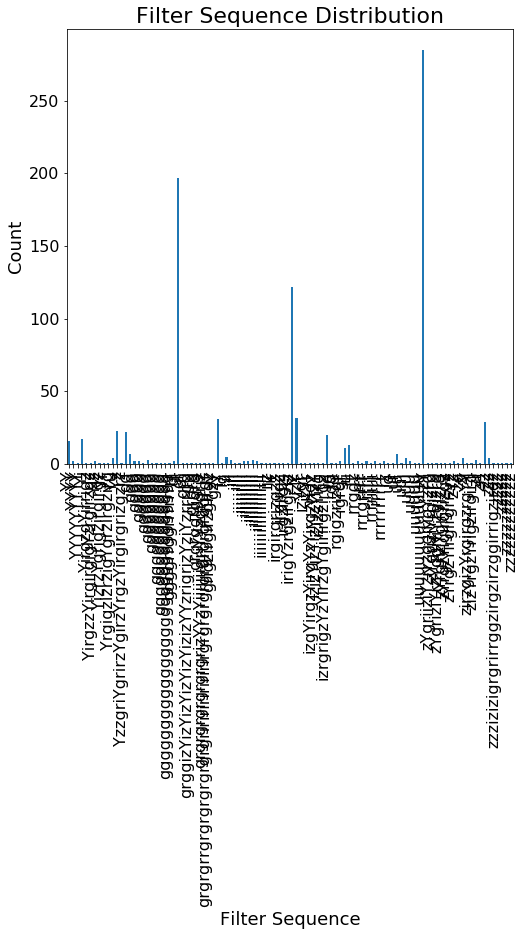

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
filter_seq_count.plot.bar(ax=ax)
ax.set_xlabel("Filter Sequence", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Filter Sequence Distribution", fontsize=22)
ax.tick_params(labelsize=16)
# ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha="right")
# ax.grid(visible=True)
plt.show(fig)
# fig.savefig(f"{fig_dir}filter_category_bar.png")
plt.close(fig)

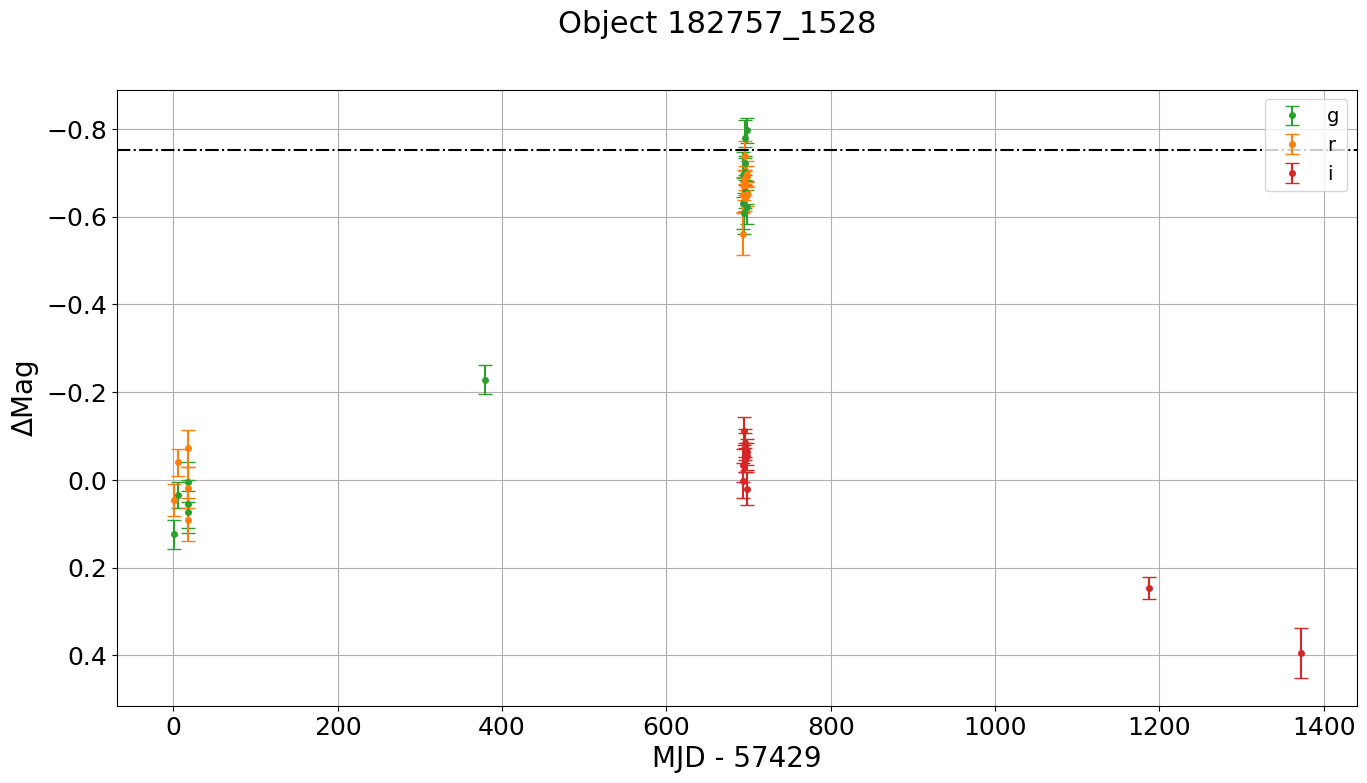

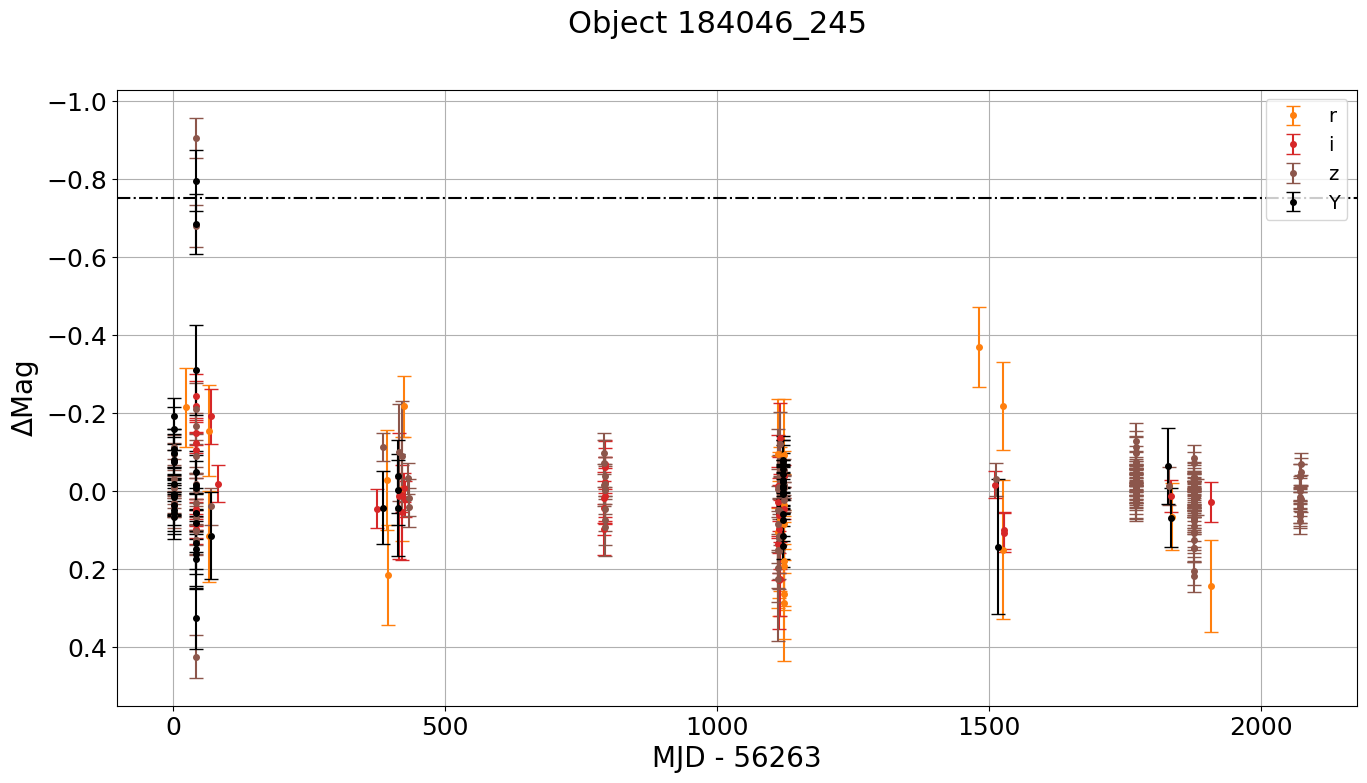

In [58]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])
flux_double = -2.5 * np.log10(2)

plot_ids = n_events_per_source_achromatic_factor.loc[n_events_per_source_achromatic_factor > 1].index
# plot_ids = filter_diffs_achromatic_factor.loc[filter_diffs_achromatic_factor > 1].index.get_level_values(0)

for oid in plot_ids:
    m_id = lc_df_achromatic_factor["objectid"] == oid
    baseline_subtracted = datalab_utils.subtract_baseline(lc_df_achromatic_factor.loc[m_id])

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    min_mjd = int(baseline_subtracted["mjd"].min())
    
    for f, c in zip(filters, colors):
        m_f = baseline_subtracted["filter"] == f
        lc_full = baseline_subtracted.loc[m_f]
    
        if len(lc_full) > 0:
            ax.errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                        yerr=lc_full["magerr_auto"], marker='.', ms=8,
                        capsize=5, color=c, ls="None", label=f)
    
    ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.invert_yaxis()
    ax.grid(visible=True)
    ax.axhline(flux_double, color='k', linestyle="-.")
        
    ax.legend(fontsize=14, loc="upper right")
    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    # fig.savefig(f"{fig_dir}182757_1528_lightcurve_baseline_subtracted.png")
    plt.close(fig)

NameError: name 'results_df' is not defined

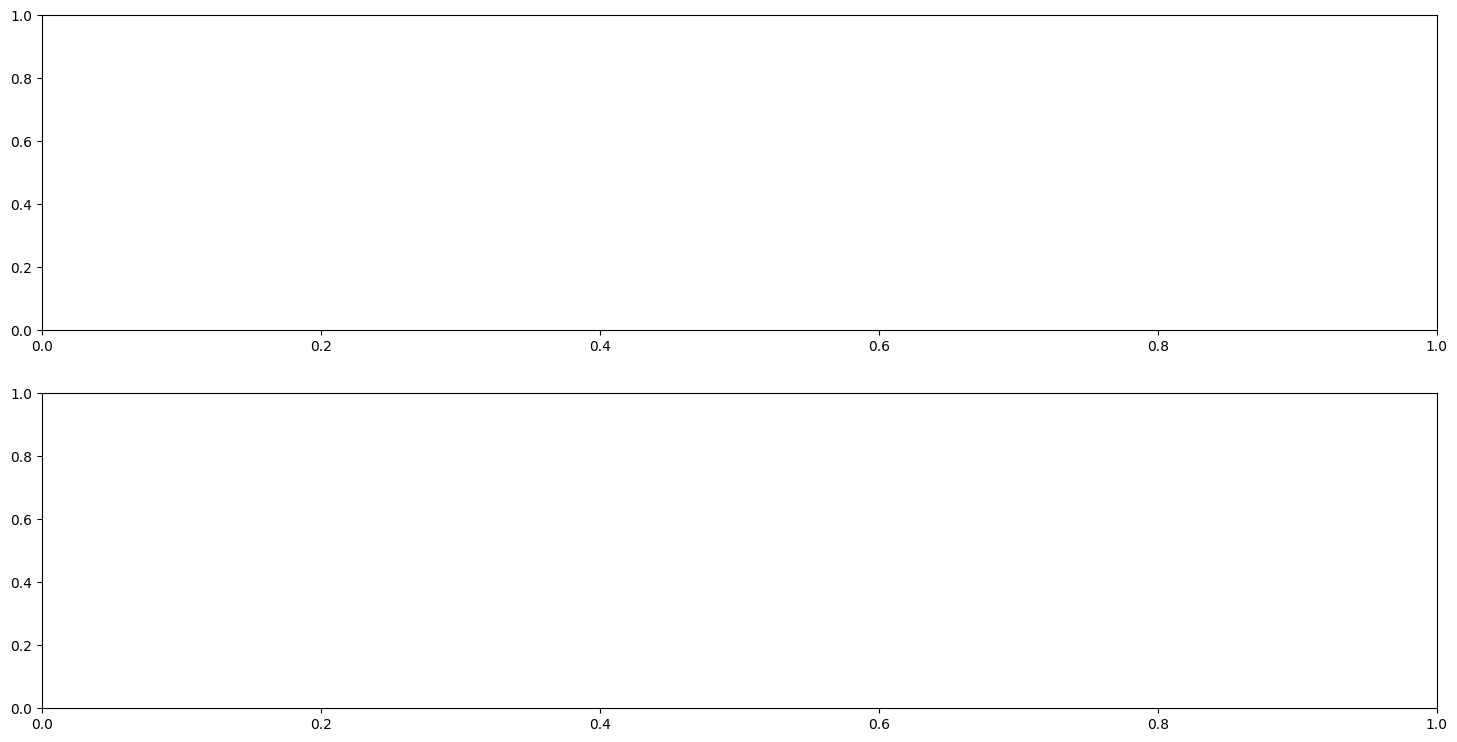

In [33]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", 'k'])
filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])

for oid in achromatic_ids[20:]:
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))
    row = results_df.loc[(oid, 0)]
    ev_start, ev_end = row["t_start"], row["t_end"]
    m_id = lc_df["objectid"] == oid

    if ~np.isfinite(ev_start):
        ev_start = lc_df.loc[m_id, "mjd"].min()
    if ~np.isfinite(ev_end):
        ev_end = lc_df.loc[m_id, "mjd"].max()
    t_delta = ev_end - ev_start
    min_mjd = int(lc_df.loc[m_id, "mjd"].min())

    for f, c in zip(filters, colors):
        m_f = lc_df["filter"] == f
        lc_full = lc_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", label=f)
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['delta_mag'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel(r'$\Delta$Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        ax.grid(visible=True)
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        ax.axhline(flux_double, color='k', linestyle="-.")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")
    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    t_lims = ((ev_start - 0.1 * t_delta) - min_mjd, (ev_end + 0.1 * t_delta) - min_mjd)
    axes[1].set_xlim(t_lims)
    fig.suptitle(f"Object {oid}", fontsize=22)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{oid}_lightcurve_baseline_subtracted.png")
    plt.close(fig)

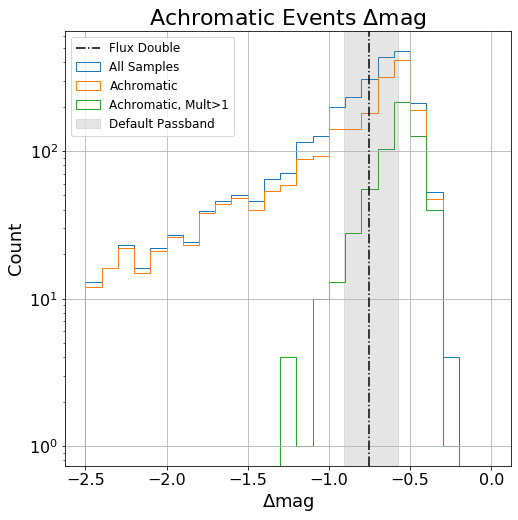

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
bright_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="All Samples")
bright_achromatic_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic")
bright_achromatic_mult2_lc.hist(column="delta_mag", ax=ax, bins=dmag_bins, histtype="step", label="Achromatic, Mult>1")
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.axvspan(-2.5 * np.log10(2.3), -2.5 * np.log10(1.7), alpha=0.2, 
           color="tab:gray", label="Default Passband")
ax.axvline(-2.5 * np.log10(2), color='k', ls="-.", label="Flux Double")
ax.set_yscale("log")
ax.tick_params(labelsize=16)
ax.legend(loc="upper left", fontsize=12)
ax.set_title(r"Achromatic Events $\Delta$mag", fontsize=22)
plt.show(fig)
# fig.savefig(f"{fig_dir}achromatic_events_deltamag.png")
plt.close(fig)

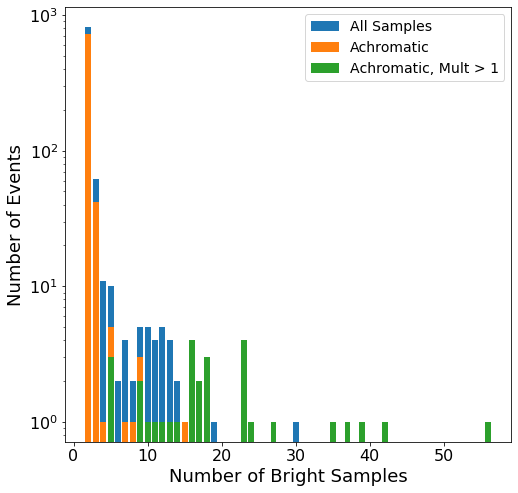

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(n_distribution.index, n_distribution, label="All Samples")
ax.bar(n_achromatic_distribution.index, n_achromatic_distribution, label="Achromatic")
ax.bar(n_achromatic_mult2_distribution.index, n_achromatic_mult2_distribution, label="Achromatic, Mult > 1")
ax.set_yscale("log")
ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Number of Bright Samples", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=16)
plt.show(fig)

In [ ]:
# n_sources_per_n_events_all = np.full(n_samples_y_all.shape, np.nan)
# n_sources_per_n_events_all[n_events_freq_df["all"].index] = n_events_freq_df["all"]
# np.place(n_sources_per_n_events_all, n_sources_per_n_events_all < 1, np.nan)
# n_samples_per_source_all = n_samples_y_all / n_sources_per_n_events_all

# n_sources_per_n_events_achromatic = np.full(n_samples_y_achromatic.shape, np.nan)
# n_sources_per_n_events_achromatic[n_events_freq_df["achromatic"].index] = n_events_freq_df["achromatic"]
# np.place(n_sources_per_n_events_achromatic, n_sources_per_n_events_achromatic < 1, np.nan)
# n_samples_per_source_achromatic = n_samples_y_achromatic / n_sources_per_n_events_achromatic

# n_sources_per_n_events_achromatic_factor = np.full(n_samples_y_achromatic_factor.shape, np.nan)
# n_sources_per_n_events_achromatic_factor[n_events_freq_df["achromatic_factor2"].index] = n_events_freq_df["achromatic_factor2"]
# np.place(n_sources_per_n_events_achromatic_factor, n_sources_per_n_events_achromatic_factor < 1, np.nan)
# n_samples_per_source_achromatic_factor = n_samples_y_achromatic_factor / n_sources_per_n_events_achromatic_factor

# normalizing_curve_all = n_samples_per_source_all[50] * n_samples_x_all / 50

# fig, ax = plt.subplots(figsize=(15, 8))
# x_ticks = n_samples_x_all[::10]

# ax.bar(n_samples_x_all, n_samples_per_source_all, width=1, label="All")
# ax.bar(n_samples_x_achromatic, n_samples_per_source_achromatic, width=1, label="Achromatic")
# ax.bar(n_samples_x_achromatic_factor, n_samples_per_source_achromatic_factor, width=1, label="Achromatic Factor2")
# ax.plot(n_samples_x_all, normalizing_curve_all, color="k", label=f"y = {n_samples_per_source_all[50]:0.2f} * x")
# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_ticks, rotation=-90)
# ax.set_xlim((x_ticks.min(), x_ticks.max()))
# ax.legend(loc="upper left", fontsize=16)
# ax.set_yscale("log")
# ax.set_xlabel("n Events Per Source", fontsize=18)
# ax.set_ylabel("Mean Number of Samples Per Source", fontsize=18)
# ax.tick_params(labelsize=16)
# # ax.set_xlim((0, 100))
# fig.savefig(f"{fig_dir}samples_per_source_hist.png")
# plt.show(fig)